In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sc.constants as cs
import sc.payoff as po
from yq.scripts import simulation as yqsm

print(pd.__version__)

2.1.2


In [103]:
paths_arr = yqsm.read_sim_data('gbm', '20231110_222722_149946', pd.Timestamp('2023-08-09'), pd.Timestamp('2023-08-10'))
print(paths_arr[1][0])

Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Total sims/length of sim_data_df for 2023-08-09 00:00:00: 3
Total sims/length of sim_data_df for 2023-08-10 00:00:00: 3
Total days is: 2

           Date     LONN.SW     SIKA.SW
0    2023-08-11  473.661553  265.686885
1    2023-08-14  469.086618  262.894438
2    2023-08-15  473.53918

In [104]:
df_sim = paths_arr[0][0]
df_sim['Date'] = pd.to_datetime(df_sim['Date'])
df_sim = df_sim.set_index('Date')
#print(df_sim)

2023-08-10 00:00:00
   payout       date
0    20.0 2023-11-06
0    20.0 2024-02-05
0    20.0 2024-05-06
0    20.0 2024-08-05
0  1000.0 2024-08-05


c:\Users\danie\Desktop\NTU Stuff\Y4S1\MH4518 Simulation Techniques in Finance\Group Project\aaaa\simulation-in-finance\code\sc\payoff.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  if barrierHit:


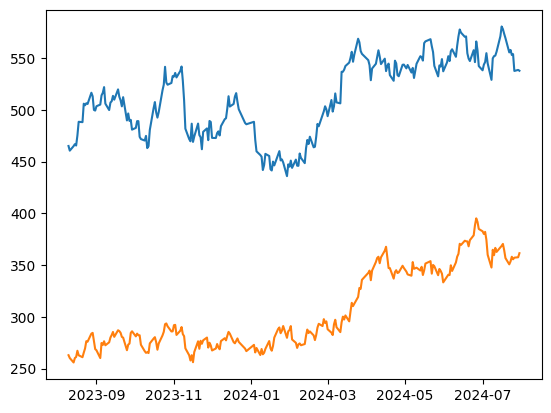

In [105]:
df_payouts = po.payouts(df_sim, False)
plt.plot(df_sim)
print(df_payouts)

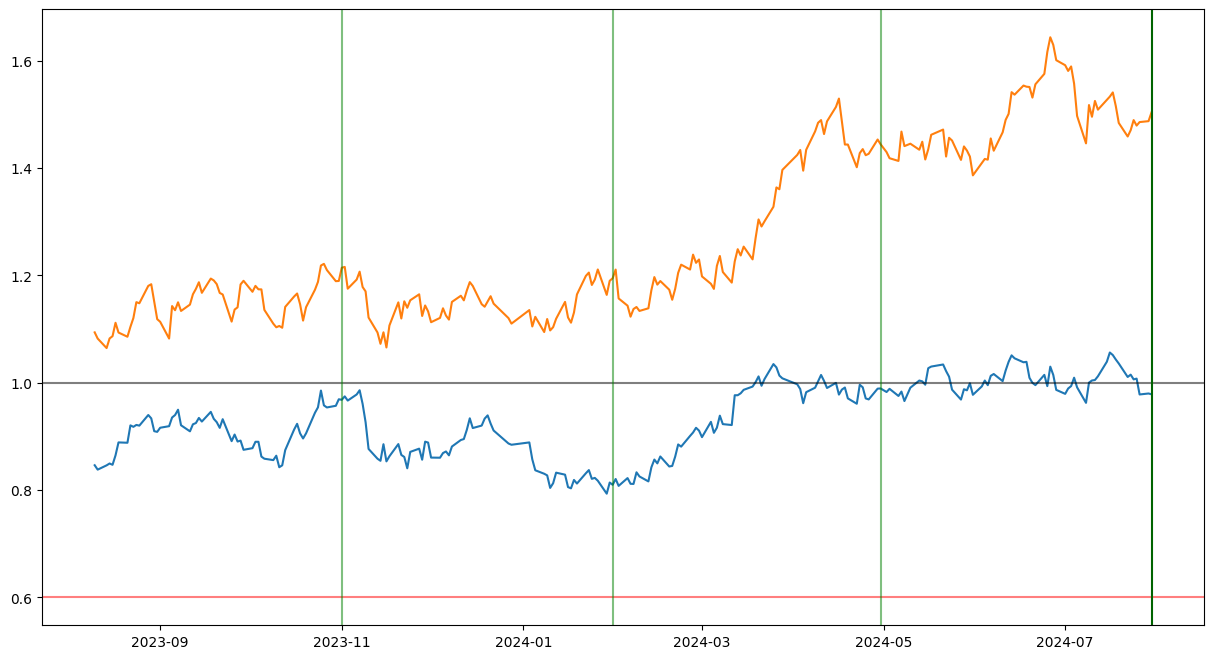

In [106]:
df_plot = df_sim
for asset in cs.ASSET_NAMES:
    df_plot[asset] = df_plot[asset] / cs.INITIAL_LEVELS[asset]
plt.figure(figsize = (15, 8))
plt.plot(df_plot)
plt.axhline(y=1, c = "black", alpha = 0.5)
plt.axhline(y = 0.6, c = "red", alpha = 0.5)
plt.axvline(x = cs.FINAL_FIXING_DATE, c = "darkgreen")
for date in cs.EARLY_REDEMPTION_OBSERVATION_DATES:
    plt.axvline(x = date, c = "green", alpha = 0.5)

In [110]:
print(po.rnv(df_payouts, pd.Timestamp('2023-01-01')))
#print(po.get_historical(pd.Timestamp('2023-08-10')))

1080.0


AttributeError: module 'sc.payoff' has no attribute 'get_historical'